In [1]:
# Import 
import os
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from itertools import permutations
import time
import pandas as pd
from joblib import dump, load
from pathlib import Path

## sourceXray
from src.sourceXray_BJ import sourceXray, compute_C, solve_H_right_inverse
from src.utils import *

## X-RAY
from src.XRAY import xray_BJ

## W 
import pysptools.abundance_maps as amp
nnls = amp.NNLS() # nonnegative constrained least squares and then row-normalize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
obj = load("data/CB_10locs_complete_nonegpm25mpm1.joblib")
df = obj["df"]
Y = obj["Y"]
ys = ['pm1', 'pm25mpm1', 'pm10mpm25', 'tspmpm10', 'bc', 'co', 'no', 'no2']
col_label = ["PM1", "PM2.5-PM1", "PM10-PM2.5", "TSP-PM10", "BC", "CO", "NO", "NO2"]
b = pd.to_numeric(df['bulldozer'], errors='coerce')
d = pd.to_numeric(df['downwind'],  errors='coerce')
df['bulldozerxdownwind'] = (b*d).astype('Int8')

In [4]:
df["date_local"].agg(["min", "max"])

min   2022-10-21 11:21:00-04:00
max   2023-06-16 23:59:00-04:00
Name: date_local, dtype: datetime64[ns, America/New_York]

In [5]:
seed = 910
K = 3

# row-stochastic Y
r = Y.to_numpy().sum(axis=1, keepdims=True)
Y_star = Y / r
n = Y_star.shape[0]
J = Y_star.shape[1]
Y_star_cube = Y_star.to_numpy().reshape(n, 1, J)

# path 
outdir = Path("results/CB")
outdir.mkdir(parents=True, exist_ok=True)

In [7]:
# H_star_hat, W_tilde_hat, mu_tilde_hat, C_hat, logvol_hat = sourceXray(Y, K, seed=seed, prune=False, verbose=True)[0]

In [8]:
# # sourceXray
# results = {}

# for min_K in [30*K, 40*K, 50*K]: # Number of hull_pts w/o pruning: 1261
#     print(f"\n=== Running experiments for min_K = {min_K} ===\n")
    
#     start = time.time()
#     H_star_hat, W_tilde_hat, mu_tilde_hat, C_hat, logvol_hat = sourceXray(Y, K, seed=seed, prune=True, min_K=min_K, verbose=True)[0]
#     end = time.time()
#     time_sourceXray = end - start
    
#     results[min_K] = {
#         "time": time_sourceXray,
#         "H_star": H_star_hat,
#         "W_tilde": W_tilde_hat, 
#         "mu_tilde": mu_tilde_hat, 
#         "C": C_hat, 
#         "logvol": logvol_hat
#     }
    
#     # save
#     dump(results[min_K], outdir/f"sourceXray_CB_nonegpm25mpm1_K3_minK{min_K}.joblib")

In [9]:
# dump(results, outdir/"sourceXray_CB_nonegpm25mpm1_K3.joblib")

In [6]:
results = load(outdir/"sourceXray_CB_nonegpm25mpm1_K3.joblib")

In [12]:
# run time in minutes
results[40*K]["time"]/60

10.526443914572399

0.6572280178722436


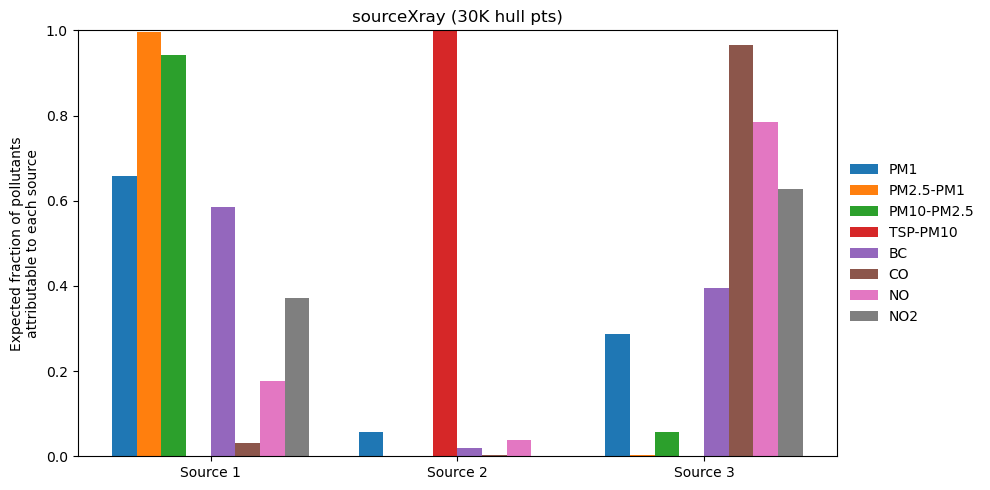

In [13]:
print(np.exp(results[30*K]["logvol"]))
plot_C_matrix_grouped_by_k(results[30*K]["C"], title="sourceXray (30K hull pts)", col_label=col_label)

0.6927689613663748


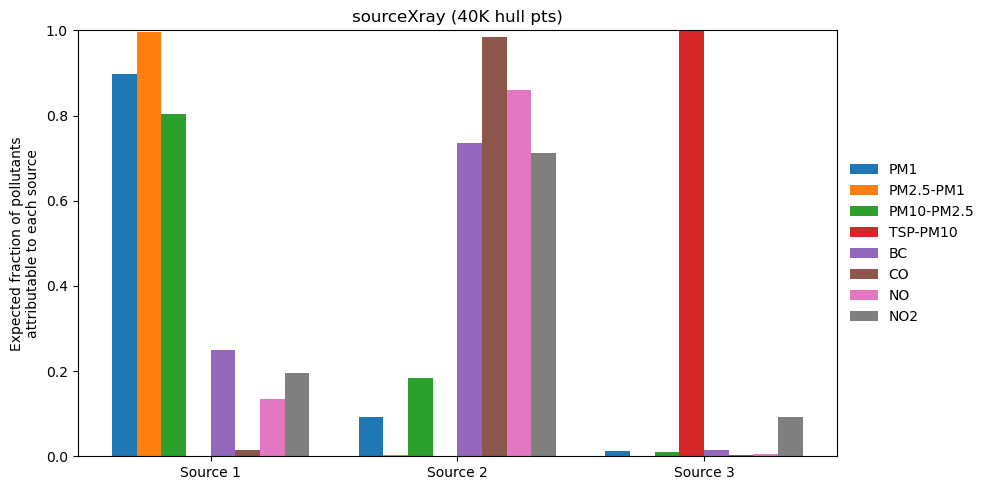

In [14]:
print(np.exp(results[40*K]["logvol"]))
plot_C_matrix_grouped_by_k(results[40*K]["C"], title="sourceXray (40K hull pts)", col_label=col_label)

0.6839304403748584


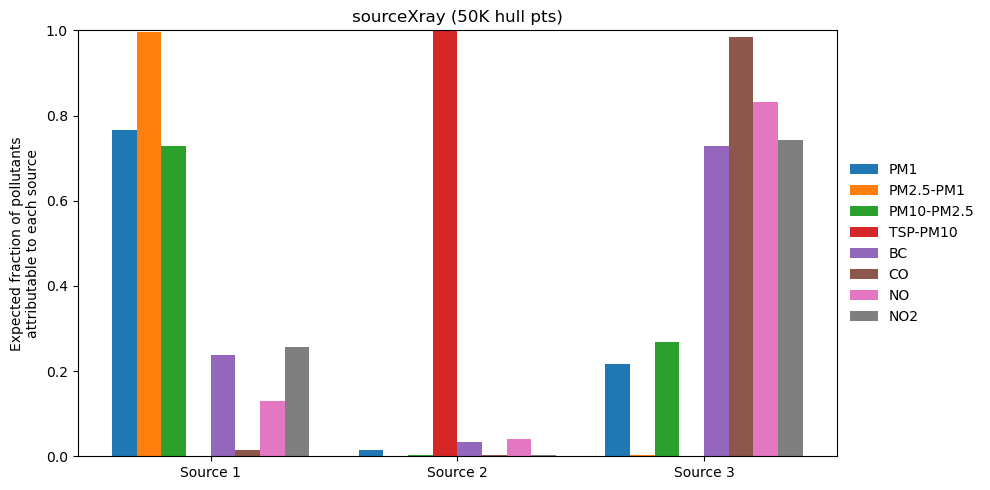

In [15]:
print(np.exp(results[50*K]["logvol"]))
plot_C_matrix_grouped_by_k(results[50*K]["C"], title="sourceXray (50K hull pts)", col_label=col_label)

In [7]:
# best K
min_K = 40*K

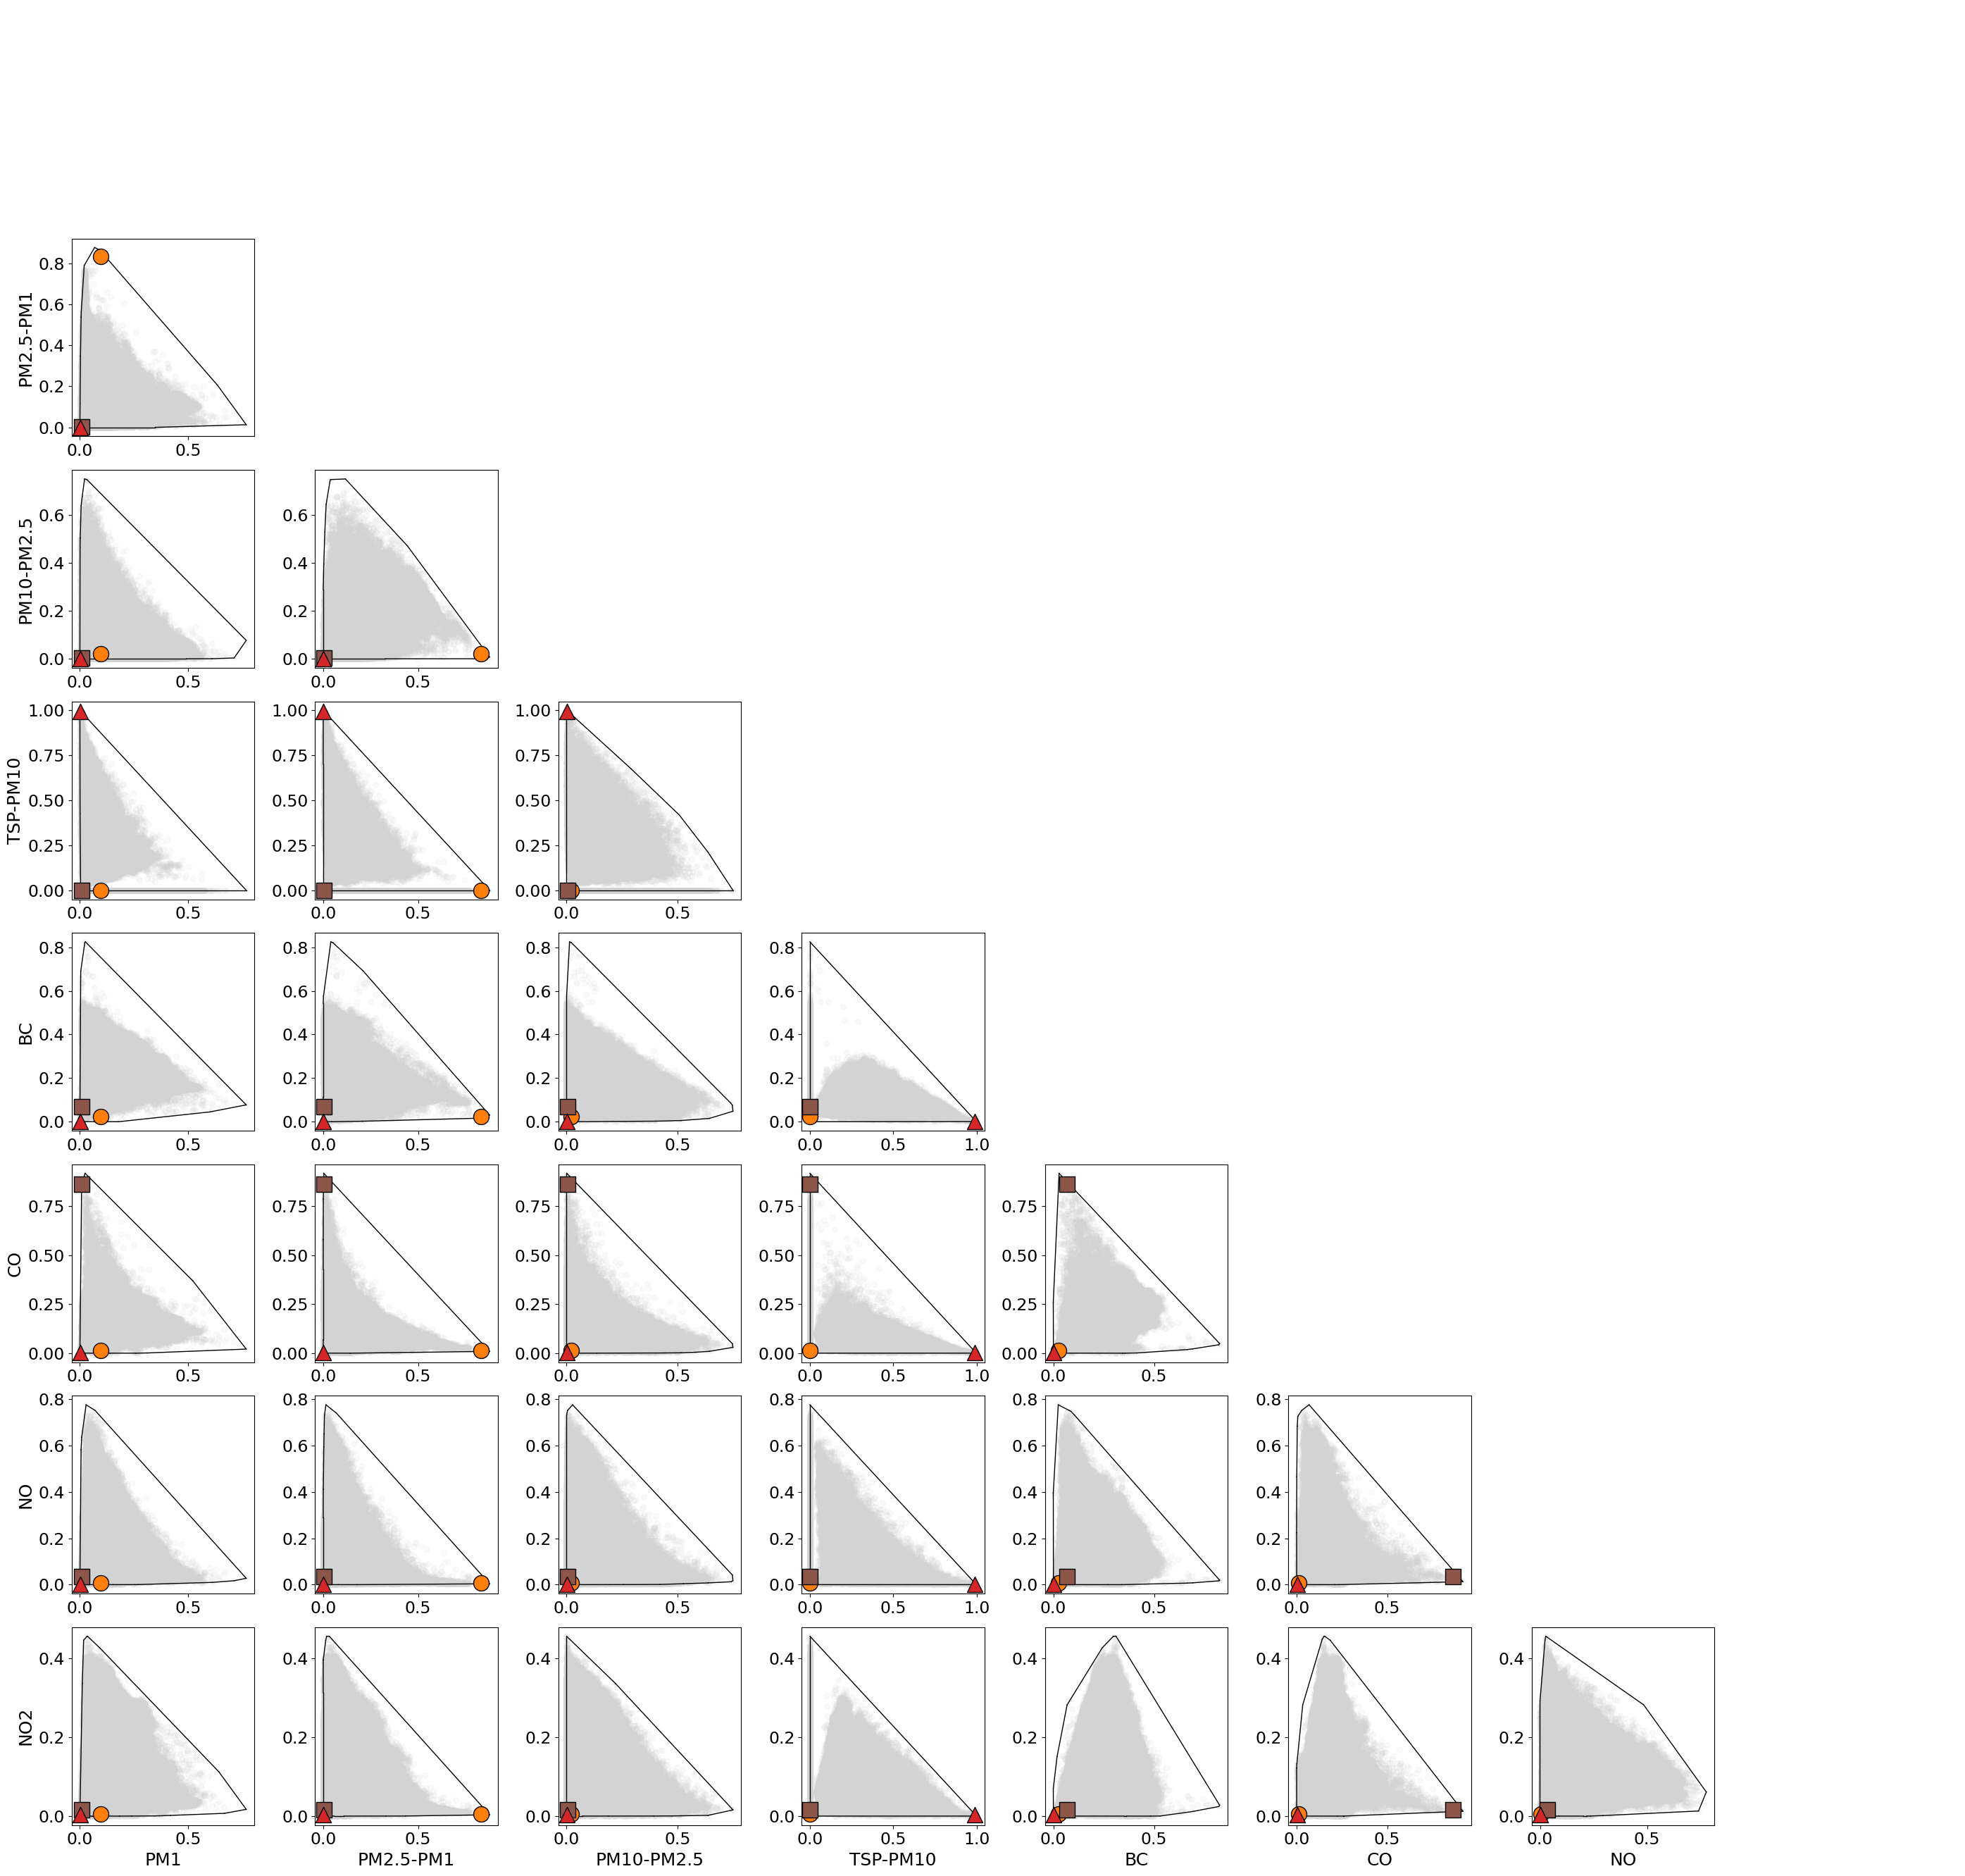

In [17]:
# Y1 (PM1), Y3 (PM10-PM2.5), Y5 (BC), Y7 (NO), Y8 (NO2) not explained well
# Y2 (PM2.5-PM1), Y4 (TSP-PM10), Y6 (CO) well covered 
plot_full_scatter_matrix(Y_star, 
                         H_hat=results[min_K]["H_star"], 
                         scatter_color="lightgray",
                         alpha=0.1, 
                         labels=col_label,
                         draw_diagonal=False,
                         title=None, 
                         quantile=None,
                         hhat_groups=range(0,K),
                         shape_map={0:"o", 1:"s", 2:"^"},            
                         color_map = {
                             0: "#ff7f0e",  # tab:orange
                             1: "#8c564b",  # tab:brown
                             2: "#d62728",  # tab:red
                            },          
                         hhat_size=250,
                         show_legend=False,
                         # savepath="results/CB/figure/CB_nonegpm25mpm1_K3_HwScatter.png"
)

Source 1: min=1.93e-12, median=1.83, max=1.04e+12
Source 2: min=1.92e-12, median=1.18, max=1.04e+12
Source 3: min=1.99e-12, median=5.24, max=1.04e+12


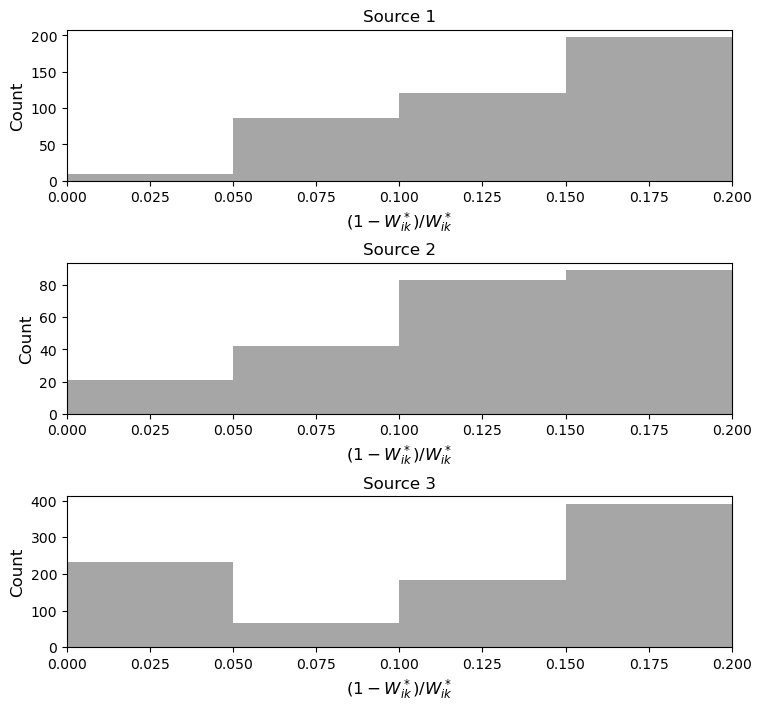

In [18]:
W_star=results[min_K]["W_tilde"]/r
edges = np.arange(0, 0.25, 0.05) 

fig, axes = plt.subplots(K, 1, figsize=(2.5 * K, 7), constrained_layout=True)
for k in range(K):
    ax = axes[k]
    col = (1-W_star[:, k])/W_star[:, k]
    vmin = col.min()
    vmed = np.median(col)
    vmax = col.max()
    print(f"Source {k+1}: min={vmin:.3g}, median={vmed:.3g}, max={vmax:.3g}")

    if col.size:
        ax.hist(col, bins=edges, color='grey', alpha=0.7, density=False)
        ax.set_xlim(0, 0.2)
        ax.set_title(f"Source {k+1}", fontsize=12)
        ax.set_xlabel("$(1-W^*_{ik})/W^*_{ik}$", fontsize=12)
        ax.set_ylabel("Count", fontsize=12)
        ax.tick_params(axis='both', labelsize=10)

# fig.savefig("results/CB/figure/CB_nonegpm25mpm1_K3_separability_check.pdf", dpi=200, bbox_inches="tight")

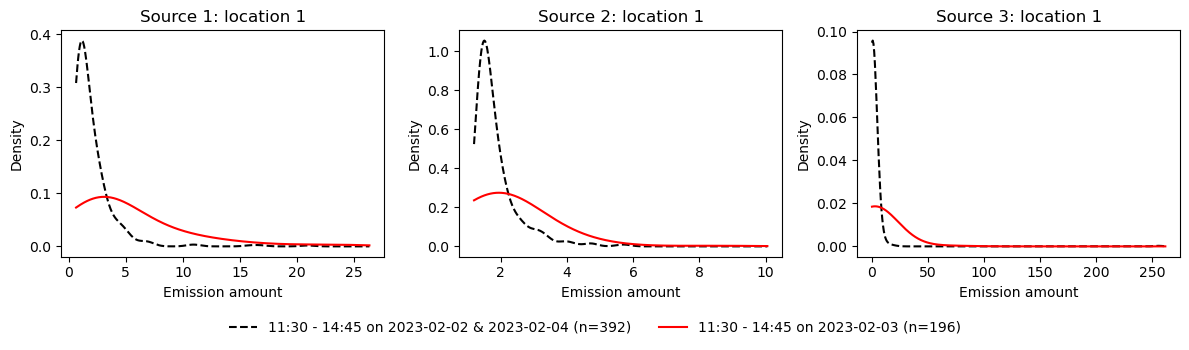

In [10]:
win1_start = pd.Timestamp('2023-02-02 11:30', tz='America/New_York')
win1_end   = pd.Timestamp('2023-02-02 14:45', tz='America/New_York')
win2_start = pd.Timestamp('2023-02-03 11:30', tz='America/New_York')
win2_end   = pd.Timestamp('2023-02-03 14:45', tz='America/New_York')
win3_start = pd.Timestamp('2023-02-04 11:30', tz='America/New_York')
win3_end   = pd.Timestamp('2023-02-04 14:45', tz='America/New_York')
in_win2 = (df['date_local'] >= win2_start) & (df['date_local'] <= win2_end)
in_win13 = (
    df['date_local'].between(win1_start, win1_end, inclusive='both')
    | df['date_local'].between(win3_start, win3_end, inclusive='both')
)
cov_03_vs_0204 = pd.Series(np.where(in_win2, 1, np.where(in_win13, 0, np.nan)), index=df.index)

idx = df.index[df['location']==1]
plot_W_by_covariate(
    results[min_K]["W_tilde"][idx], 
    covariate = cov_03_vs_0204[idx], 
    xlabel="Emission amount",
    panel_title=[f"Source {k+1}: location 1" for k in range(0, K)],
    include_nan=False,
    label_map={1:"11:30 - 14:45 on 2023-02-03", 0:"11:30 - 14:45 on 2023-02-02 & 2023-02-04"}, 
    color_map={1:"red", 0:"black"},
    linestyle_map={1:"-", 0:"--"},
    legend_outside=True, 
    legend_loc="bottom", 
    legend_position_adjust=0.1, 
    # savepath="results/CB/figure/bulldozerstuck_Wdensity_loc1.pdf"
)

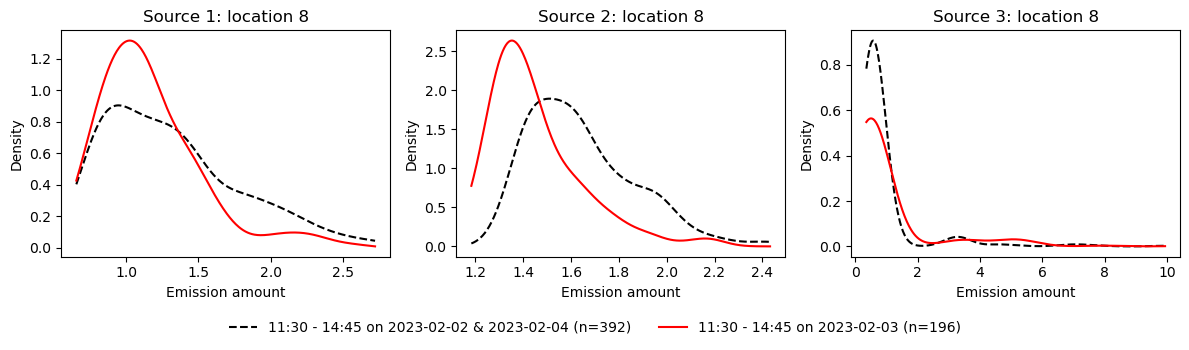

In [11]:
idx = df.index[df['location']==8]
plot_W_by_covariate(
    results[min_K]["W_tilde"][idx], 
    covariate = cov_03_vs_0204[idx], 
    xlabel="Emission amount",
    panel_title=[f"Source {k+1}: location 8" for k in range(0, K)],
    include_nan=False,
    label_map={1:"11:30 - 14:45 on 2023-02-03", 0:"11:30 - 14:45 on 2023-02-02 & 2023-02-04"}, 
    color_map={1:"red", 0:"black"},
    linestyle_map={1:"-", 0:"--"},
    legend_outside=True, 
    legend_loc="bottom", 
    legend_position_adjust=0.1,
    # savepath="results/CB/figure/bulldozerstuck_Wdensity_loc8.png"
)

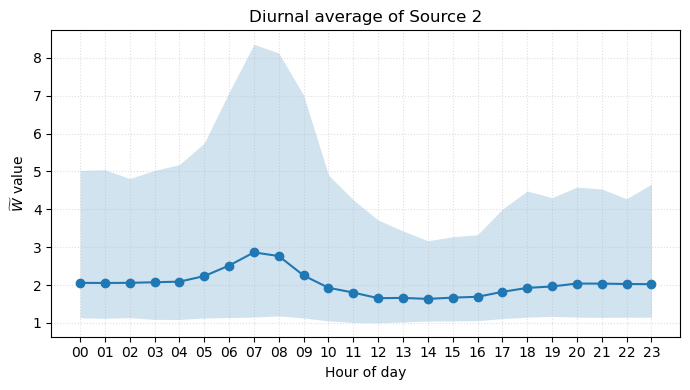

In [21]:
plot_diurnal_W(W = results[min_K]["W_tilde"], 
               columnidx=1, 
               timestamps = df['date_local'], 
               covariate=None, 
               agg="mean", 
               quantiles=(0.025, 0.975),
               figsize=(7,4),
               title="Diurnal average of Source 2", 
               ylabel="$\widetilde{W}$ value")

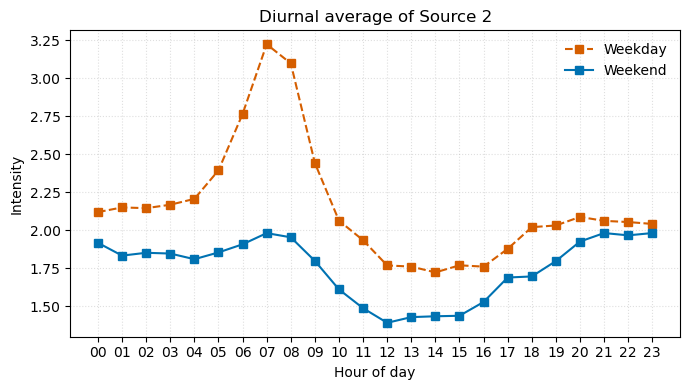

In [22]:
week = np.where(df['date_local'].dt.dayofweek >= 5, 'Weekend', 'Weekday') # Sat=5, Sun=6
plot_diurnal_W(W = results[min_K]["W_tilde"], 
               columnidx=1, 
               timestamps = df['date_local'], 
               covariate=week, 
               agg="mean", 
               quantiles=None,
               figsize=(7,4),
               legend_title=None,
               title="Diurnal average of Source 2", 
               ylabel="Intensity", 
               color_map={"Weekend": "#0072B2", "Weekday": "#D55E00"},
               linestyle_map={"Weekend": "-", "Weekday": "--"},
               point_map={"Weekend": "s", "Weekday": "s"},   
               # savepath="results/CB/figure/CB_nonegpm25mpm1_K3_traffic_source_diurnal.pdf"
)

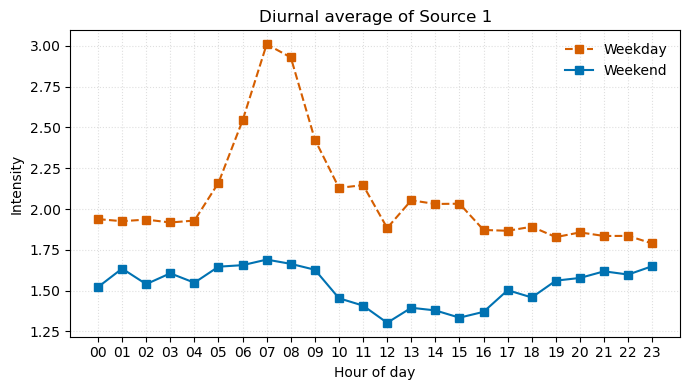

In [23]:
plot_diurnal_W(W = results[min_K]["W_tilde"], 
               columnidx=0, 
               timestamps = df['date_local'], 
               covariate=week, 
               agg="mean", 
               quantiles=None,
               figsize=(7,4),
               legend_title=None,
               title="Diurnal average of Source 1", 
               ylabel="Intensity", 
               color_map={"Weekend": "#0072B2", "Weekday": "#D55E00"},
               linestyle_map={"Weekend": "-", "Weekday": "--"},
               point_map={"Weekend": "s", "Weekday": "s"},   
)

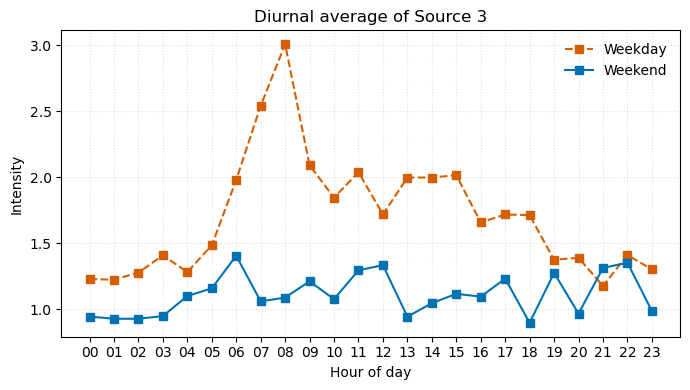

In [24]:
plot_diurnal_W(W = results[min_K]["W_tilde"], 
               columnidx=2, 
               timestamps = df['date_local'], 
               covariate=week, 
               agg="mean", 
               quantiles=None,
               figsize=(7,4),
               legend_title=None,
               title="Diurnal average of Source 3", 
               ylabel="Intensity", 
               color_map={"Weekend": "#0072B2", "Weekday": "#D55E00"},
               linestyle_map={"Weekend": "-", "Weekday": "--"},
               point_map={"Weekend": "s", "Weekday": "s"},   
)

In [8]:
ss = [f"Source {i+1}" for i in range(K)]
W_df = pd.DataFrame(results[min_K]["W_tilde"], columns=ss)
W_df = pd.concat([df[["date_local", "location", "bulldozer"]], 
                  W_df.reset_index(drop=True)], axis=1)

In [12]:
acc_start = win2_start
acc_end = win2_end

start = pd.Timestamp('2023-02-02 00:00:00', tz='America/New_York')
end   = pd.Timestamp('2023-02-04 23:59:00', tz='America/New_York')

mm = (W_df['date_local'] >= start) & (W_df['date_local'] <= end)
W_df_subset = W_df.loc[mm].copy()

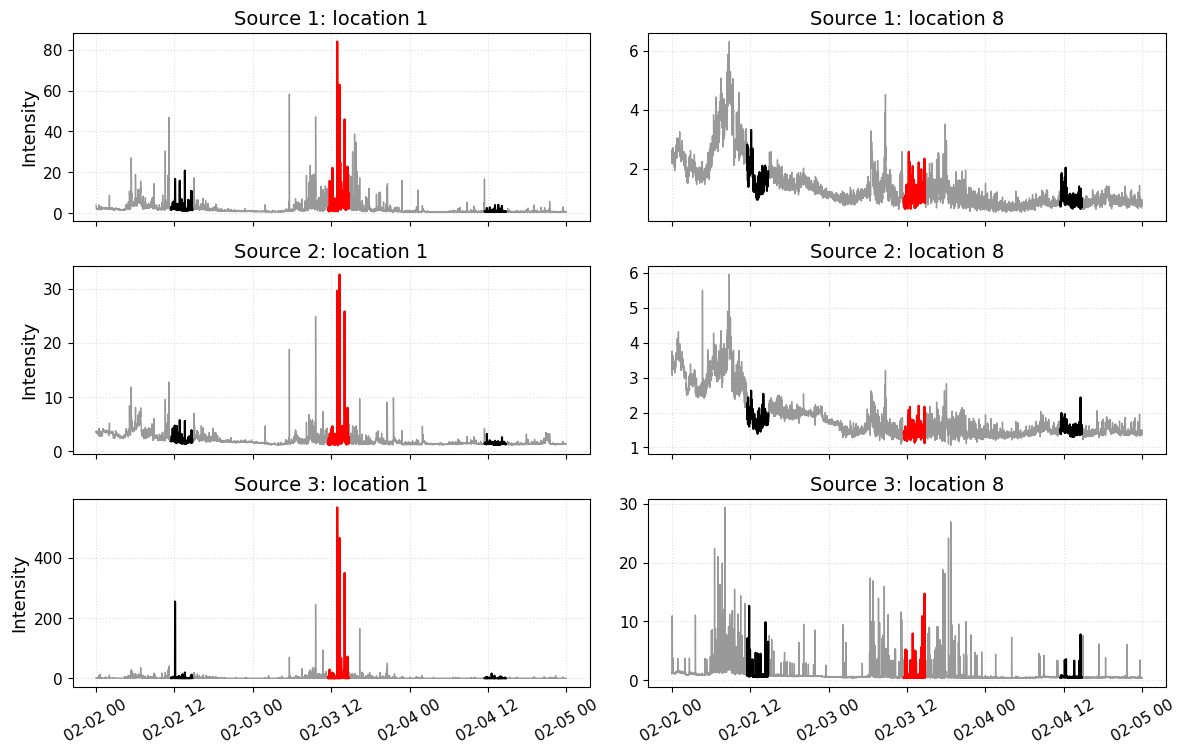

In [13]:
plot_timeseries_facets(W_df_subset, 
                       cols=ss,
                       time_col='date_local',
                       ncols=2, 
                       figsize_per_panel=(6, 2.6), # (width, height) per panel
                       sharex=True,
                       sharey=False,
                       ylabel="Intensity", 
                       lw=1,
                       alpha=0.8,
                       xrotation=30,
                       covariate="location", 
                       label_map={1:"location 1", 8:"location 8"},
                       facet_by_group=True,
                       highlight=[(acc_start, acc_end), (win1_start, win1_end), (win3_start, win3_end)], 
                       highlight_color=["red", "black", "black"], 
                       # savepath="results/CB/figure/CB_nonegpm25mpm1_K3_bulldozerstuck_timeseries_W_byloc.pdf"
                      ) 

In [14]:
W_df

,date_local,location,bulldozer,Source 1,Source 2,Source 3
0,2022-10-21 11:21:00-04:00,1,NaN,4.162001,2.610662,1.173459
1,2022-10-21 11:22:00-04:00,1,NaN,2.615402,2.288066,2.397852
2,2022-10-21 11:23:00-04:00,1,NaN,2.606365,2.183233,0.860056
3,2022-10-21 11:24:00-04:00,1,NaN,2.061096,2.123536,2.256600
4,2022-10-21 11:25:00-04:00,1,NaN,2.007504,1.919872,0.792720
...,...,...,...,...,...,...
451941,2023-04-19 03:02:00-04:00,8,NaN,1.025944,1.532627,0.518514
451942,2023-04-19 03:03:00-04:00,8,NaN,1.158724,1.555676,0.511086
451943,2023-04-19 03:04:00-04:00,8,NaN,1.360519,1.564969,0.500721
451944,2023-04-19 03:05:00-04:00,8,NaN,1.213221,1.815202,0.671863


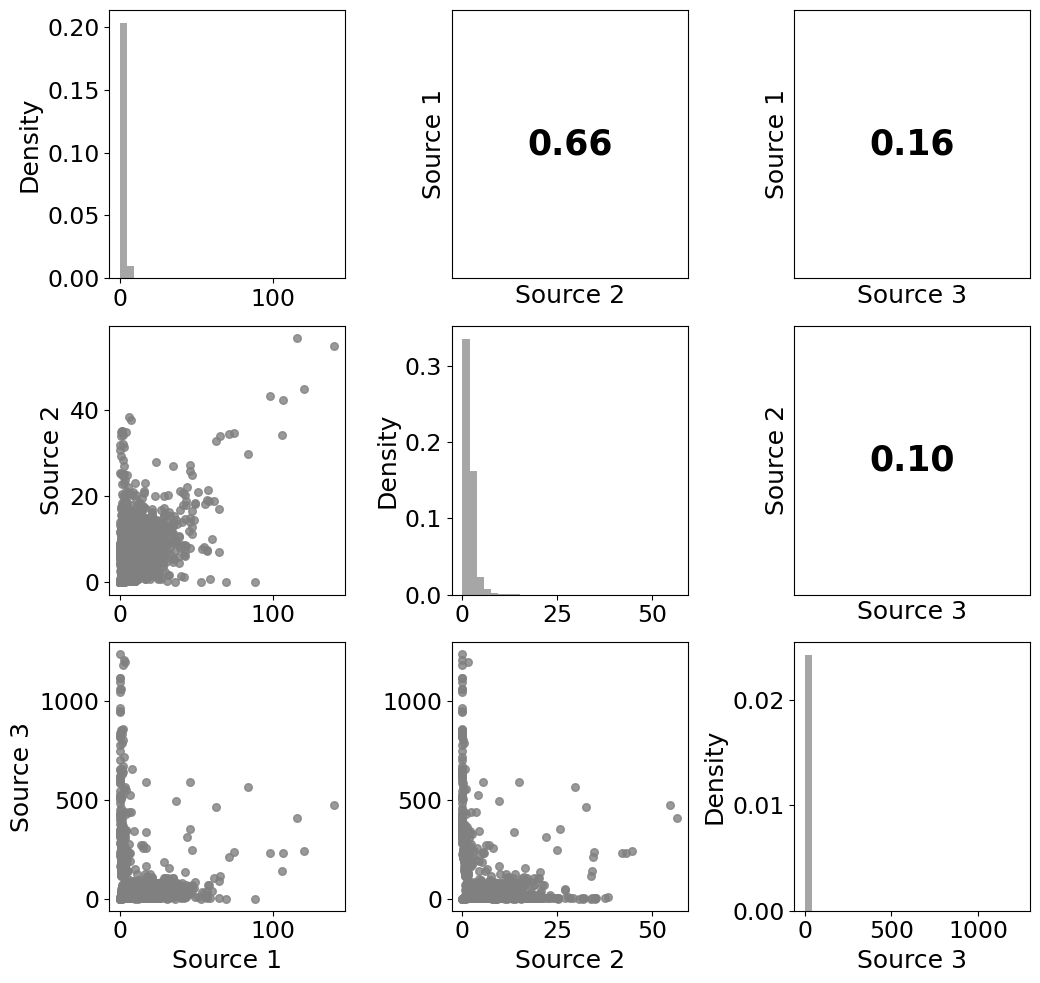

In [17]:
plot_full_scatter_matrix(W_df[ss],
                         alpha=0.8, 
                         draw_diagonal=True,
                         title=None, 
                         quantile=None,
                         convexhull=False,
                         draw_upper_corr=True,
                         corr_fmt="{:.2f}",
                         corr_fontsize=25,          
)

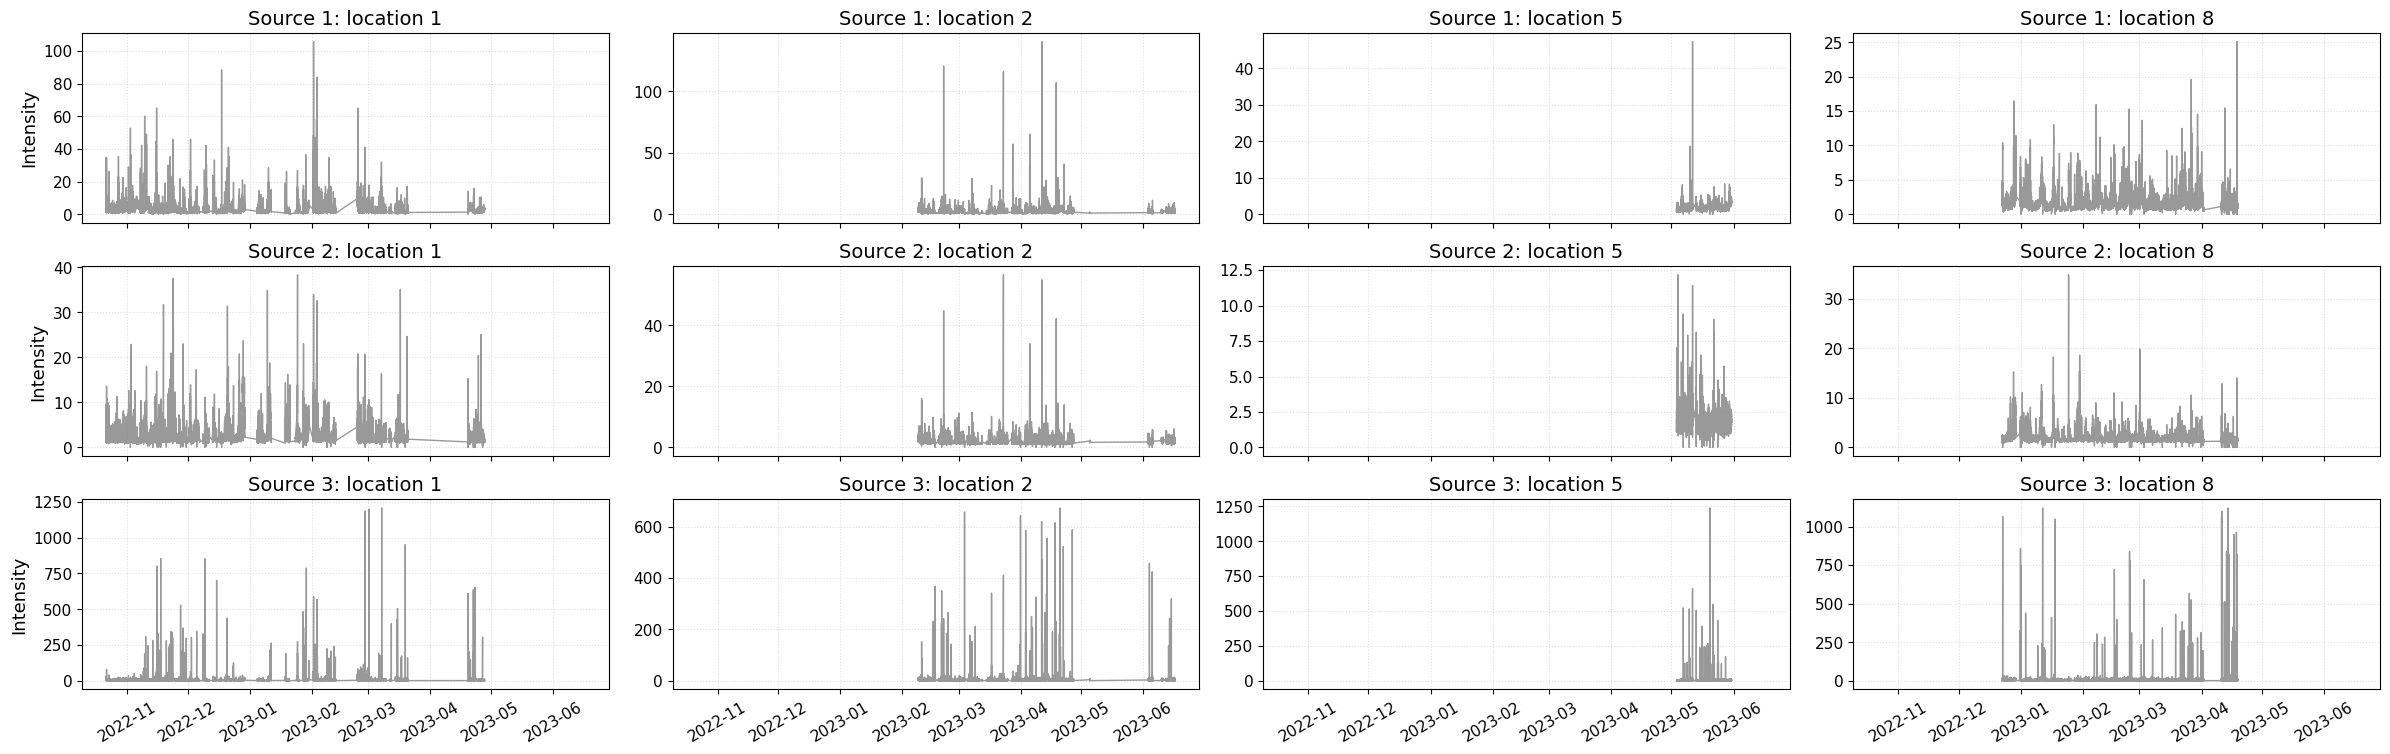

In [15]:
plot_timeseries_facets(W_df, 
                       cols=ss,
                       time_col='date_local',
                       ncols=4, 
                       figsize_per_panel=(6, 2.6), # (width, height) per panel
                       sharex=True,
                       sharey=False,
                       ylabel="Intensity", 
                       lw=1,
                       alpha=0.8,
                       xrotation=30,
                       title=None, 
                       covariate="location", 
                       label_map={1:"location 1", 2:"location 2", 5:"location 5", 8:"location 8"},
                       facet_by_group=True,
                      )

In [16]:
W_df[ss].quantile([0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1])

,Source 1,Source 2,Source 3
0.50,1.442621,1.672282,0.604038
0.70,2.006766,2.040923,0.867610
0.80,2.524568,2.388923,1.478510
0.90,3.543683,3.173338,2.876354
0.95,4.666009,4.209510,4.722456
0.99,7.461358,7.051432,11.296681
1.00,140.367956,56.499850,1238.067740


In [225]:
def summarize_exceedance_runs(
    df: pd.DataFrame,
    ss: list[str] = ['Source 1', 'Source 2', 'Source 3'],
    q: float = 0.9,
    loc_col: str = "location",
    time_col: str = "date_local",
):
    """
    For each location and each source column in `ss`, compute:
      - q-threshold
      - lengths of all consecutive threshold-exceeding runs
      - number of exceedance events (runs of any length)
      - longest run and its start/end times
      - timestamps belonging to the longest run

    Returns
    -------
    dict
        Nested dict: out[loc]["n_rows"] and out[loc][col][...stats...].
    """
    out = {}

    for loc, df_loc in df.groupby(loc_col, observed=True):
        # ensure sorted in time within each location
        df_loc = df_loc.sort_values(time_col)

        # initialize container for this location
        out[loc] = {}

        # save number of rows for this location
        out[loc]["n_rows"] = len(df_loc)

        for col in ss:
            # 1) percentile threshold of each source
            thr = df[col].quantile(q)

            # 2) boolean mask: above threshold?
            mask = df_loc[col] > thr

            # 3) identify consecutive True-runs (within this location)
            group_id = (mask != mask.shift(fill_value=False)).cumsum()

            # Sum within each group: gives length of True-runs, 0 for False-runs
            run_lengths = mask.groupby(group_id).sum()

            # Keep only the runs where mask was True
            run_lengths = run_lengths[run_lengths > 0].astype(int)

            if not run_lengths.empty:
                # group id of the longest run
                max_group = run_lengths.idxmax()
                max_duration = int(run_lengths.loc[max_group])

                # all time_col values in that longest run
                max_run_dates = df_loc.loc[(group_id == max_group) & mask, time_col]

                max_run_start = max_run_dates.iloc[0]
                max_run_end   = max_run_dates.iloc[-1]

                # number of threshold-exceeding events (runs of any length)
                n_events = int(run_lengths.size)
            else:
                n_events = 0
                mean_duration = 0
                max_duration = 0
                max_run_start = None
                max_run_end = None
                max_run_dates = []

            out[loc][col] = {
                "threshold": thr,
                "runs": run_lengths,            # each value = length in minutes
                "n_events": n_events,           # number of exceedance events
                "mean_duration": float(run_lengths.mean()),
                "max_duration": max_duration,
                "max_run_start": max_run_start, # first minute in max run
                "max_run_end": max_run_end,     # last minute in max run
                "max_run_dates": list(max_run_dates),
            }

    return out

In [226]:
out_all = {}
q_list = [0.9, 0.95, 0.99]
for q in q_list:
    out_all[q] = summarize_exceedance_runs(
            W_df,
            ss,
            q,
            loc_col = "location",
            time_col = "date_local",)

In [227]:
summary_tab = {}
for col in ss:
    summary_tab_ss = {}
    for loc in [1,2,5,8]:
        for q in q_list:
            n_rows = out_all[q][loc]["n_rows"]
            total = out_all[q][loc][col]["runs"].sum()
            n_events = out_all[q][loc][col]["n_events"]
            row_key = (loc, int(q * 100))
            summary_tab_ss[row_key] = {
                "n_events": n_events,
                "events_per_hour": n_events / n_rows * 60,
                "exceed_rate": total / n_rows * 100,          
                "mean_duration": out_all[q][loc][col]["mean_duration"],               
                "max_duration": out_all[q][loc][col]["max_duration"],
                "duration_per_day": total / n_rows * 60 * 24 
            }
    summary_tab[col] = summary_tab_ss

In [239]:
df_s1 = pd.DataFrame.from_dict(summary_tab["Source 1"], orient="index")

# make the index nice: (location, percentile)
df_s1.index = pd.MultiIndex.from_tuples(
    df_s1.index, names=["location", "percentile"]
)

# sort by location then percentile and round to 3 decimals
df_s1 = df_s1.sort_index().round(1)

print(df_s1)

                     n_events  events_per_hour  exceed_rate  mean_duration  \
location percentile                                                          
1        90              5079              1.9         17.0            5.3   
         95              3434              1.3          9.3            4.3   
         99              1369              0.5          2.3            2.6   
2        90              1693              0.9          7.2            4.7   
         95               871              0.5          3.3            4.1   
         99               244              0.1          0.6            2.5   
5        90               248              0.4          4.9            7.3   
         95               110              0.2          1.3            4.2   
         99                 8              0.0          0.1            3.5   
8        90              1238              0.5          5.8            6.9   
         95               650              0.3          2.6     

In [240]:
df_s3 = pd.DataFrame.from_dict(summary_tab["Source 3"], orient="index")

# make the index nice: (location, percentile)
df_s3.index = pd.MultiIndex.from_tuples(
    df_s3.index, names=["location", "percentile"]
)

# sort by location then percentile and round to 3 decimals
df_s3 = df_s3.sort_index().round(3)

print(df_s3)

                     n_events  events_per_hour  exceed_rate  mean_duration  \
location percentile                                                          
1        90             12555            4.765       12.954          1.631   
         95              7751            2.942        6.877          1.403   
         99              2025            0.769        1.647          1.286   
2        90              6709            3.655        9.206          1.511   
         95              3555            1.936        4.312          1.336   
         99               508            0.277        0.621          1.346   
5        90              2295            3.740        7.735          1.241   
         95              1071            1.745        3.387          1.164   
         99                87            0.142        0.293          1.241   
8        90              8378            3.422        7.984          1.400   
         95              4698            1.919        3.900     

In [241]:
df_s2 = pd.DataFrame.from_dict(summary_tab["Source 2"], orient="index")

# make the index nice: (location, percentile)
df_s2.index = pd.MultiIndex.from_tuples(
    df_s2.index, names=["location", "percentile"]
)

# sort by location then percentile and round to 3 decimals
df_s2 = df_s2.sort_index().round(3)

print(df_s2)

                     n_events  events_per_hour  exceed_rate  mean_duration  \
location percentile                                                          
1        90              3393            1.288       16.303          7.597   
         95              1882            0.714        8.971          7.536   
         99               546            0.207        2.061          5.967   
2        90              1115            0.607        6.972          6.887   
         95               534            0.291        2.860          5.899   
         99               121            0.066        0.416          3.785   
5        90                82            0.134        0.902          4.049   
         95                48            0.078        0.320          2.458   
         99                 9            0.015        0.027          1.111   
8        90              1177            0.481        7.768          9.693   
         95               564            0.230        3.504     